In [223]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cryptowatch as cw

In [224]:
Markets = ["kraken:btceur", "kraken:etheur", "kraken:linkeur", "kraken:waveseur"]
#  ["kraken:ltceur", "kraken:bateur" "kraken:eoseur" "kraken:algoeur" "kraken:repeur" "kraken:bcheur",
#   "kraken:adaeur", "kraken:linkeur", "kraken:atomeur","kraken:dasheur", "kraken:daieur", "kraken:dogeur",
#   "kraken:etceur", "kraken:gnoeur", "kraken:icxeur", "kraken:lskeur", "kraken:mlneur", "kraken:xmreur", 
#   "kraken:nanoeur", "kraken:omgeur", "kraken:paxgeur", "kraken:qtumeur", "kraken:xrpeur", "kraken:sceur",
#   "kraken:xlmeur", "kraken:usdteur", "kraken:xtzeur", "kraken:trxeur", "kraken:usdceur", "kraken:waveseur", 
#   "kraken:zeceur" ] 

StartDate = '2017-01-01'
# EndDate = ''

In [225]:
def PullMarkets(MarketList):
    MarketDf = pd.DataFrame()
    
    for m in MarketList:
        try:
            CoinName = m.split(':')[1]
            candles = cw.markets.get(m, ohlc=True)
            # Convert to data-frame
            df = pd.DataFrame(candles.of_1d, columns=['Date', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'Volum', 'NA'])
            # Drop the last column
            df.drop(columns=['NA'], inplace=True)
            
            # Set close time to second
            df['Date'] = pd.to_datetime(df['Date'], unit='s')

            # Set close time as index
            df.set_index('Date', inplace=True)

            # Adjusting the data frame according the defined start
            df = df.loc[df.index >= pd.to_datetime(StartDate)]
            # df = df.loc[df.index >= pd.to_datetime(EndDate)]
            
            if MarketDf.empty:
                MarketDf = pd.DataFrame(index=df.index)
                MarketDf[CoinName] = df['ClosePrice']
            else:
                MarketDf = pd.concat([MarketDf, df['ClosePrice']], axis=1)
                MarketDf = MarketDf.rename(columns={'ClosePrice':CoinName})
            
        finally:
            time.sleep(0.5)
        
    return MarketDf

In [226]:
Portfolio = PullMarkets(Markets)
Portfolio

,btceur,etheur,linkeur,waveseur
Date,,,,
2017-01-01,914.60,7.61820,NaN,NaN
2017-01-02,947.21,7.74099,NaN,NaN
2017-01-03,971.76,7.99999,NaN,NaN
2017-01-04,994.01,9.25000,NaN,NaN
2017-01-05,1069.60,10.41805,NaN,NaN
...,...,...,...,...
2020-11-11,12970.00,381.93000,11.03000,3.2402
2020-11-12,13323.90,394.01000,10.85000,3.2062
2020-11-13,13810.00,392.26000,10.52627,3.2992


In [227]:
# Mean
Portfolio.pct_change(1).mean()

btceur      0.002822
etheur      0.004400
linkeur     0.006436
waveseur    0.004367
dtype: float64

In [228]:
Portfolio.corr()

,btceur,etheur,linkeur,waveseur
btceur,1.000000,0.548911,0.751563,0.767514
etheur,0.548911,1.000000,0.939030,0.919414
linkeur,0.751563,0.939030,1.000000,0.934863
waveseur,0.767514,0.919414,0.934863,1.000000


In [229]:
# Logarithmic daily return
PortfolioLogDailyRet = np.log(Portfolio/Portfolio.shift(1))
PortfolioLogDailyRet.head()

,btceur,etheur,linkeur,waveseur
Date,,,,
2017-01-01,NaN,NaN,NaN,NaN
2017-01-02,0.035034,0.015989,NaN,NaN
2017-01-03,0.025588,0.032911,NaN,NaN
2017-01-04,0.022638,0.145183,NaN,NaN
2017-01-05,0.073293,0.118916,NaN,NaN


In [230]:
# Covariance of the log return
PortfolioLogDailyRet.cov()*365.25

,btceur,etheur,linkeur,waveseur
btceur,0.674073,0.617791,0.615685,0.504763
etheur,0.617791,1.184745,0.901914,0.685988
linkeur,0.615685,0.901914,1.583061,0.762647
waveseur,0.504763,0.685988,0.762647,1.337412


In [231]:
# To always get the same random number if replaying the portfolio
# np.random.seed(101)

NbPortfolios = 100000
AllWeights = np.zeros((NbPortfolios, len(PortfolioLogDailyRet.columns)))
ret_array = np.zeros(NbPortfolios)
vol_array = np.zeros(NbPortfolios)
sharpe_array = np.zeros(NbPortfolios)

# Random simulation of the portfolio
for ind in range(NbPortfolios):
    # Rand weights and normalization
    weights = np.array(np.random.random(len(Portfolio.columns)))
    weights = weights/np.sum(weights)

    # Save the weights here
    AllWeights[ind,:] = weights    

    # Expected Return
    ret_array[ind] = np.sum(PortfolioLogDailyRet.mean() * weights * 365.25)

    # Expected volatility
    vol_array[ind] = np.sqrt(np.dot(weights.T, np.dot(PortfolioLogDailyRet.cov() * 365.25, weights)))

    # Sharpe ratio
    sharpe_array[ind] = ret_array[ind]/vol_array[ind]

In [232]:
# Maximum sharpe ratio and location
print('Optimal Sharpe Ratio:')
print(sharpe_array.max())
# print(sharpe_array.argmax())
print ('\nOptimal weights:')
for optw in zip(Markets, AllWeights[sharpe_array.argmax()]):
    print(optw)

Optimal Sharpe Ratio:
1.2691130483234718

Optimal weights:
('kraken:btceur', 0.05194022222381514)
('kraken:etheur', 0.09287523305734874)
('kraken:linkeur', 0.7496255826195555)
('kraken:waveseur', 0.1055589620992807)


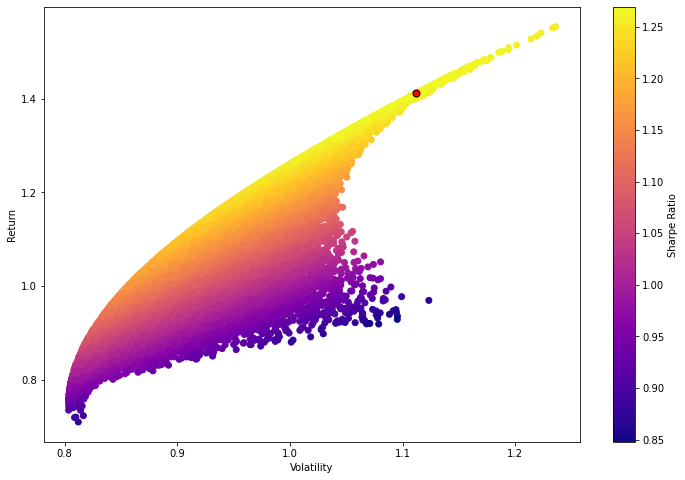

In [233]:
# Scatter plot for the portfolio
plt.figure(figsize=(12,8))
plt.scatter(vol_array, ret_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Scatter the best sharpe ratio
max_sr_ret = ret_array[sharpe_array.argmax()]
max_sr_vol = vol_array[sharpe_array.argmax()]

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

In [234]:
# Much better optimization
from scipy.optimize import minimize

# define a couple of functions
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(PortfolioLogDailyRet.mean() * weights) * 365.25
    vol = np.sqrt(np.dot(weights.T, np.dot(PortfolioLogDailyRet.cov()*365.25, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharp(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    # return 0 if the sum of the weights is one
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [235]:
cons = ({"type":"eq", "fun":check_sum})
bounds = tuple([(0,1)] * len(PortfolioLogDailyRet.columns))
init_guess = [1/len(PortfolioLogDailyRet.columns) for i in range(len(PortfolioLogDailyRet.columns))] 
opt_results = minimize(neg_sharp, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [236]:
print('\nOptimal weights:')
for optw in zip(Markets, opt_results.x):
    print(optw)

print('\nOptimal ret/vol/sr:')
print(get_ret_vol_sr(opt_results.x))


Optimal weights:
('kraken:btceur', 0.05697577342969454)
('kraken:etheur', 0.08650609586762384)
('kraken:linkeur', 0.7393639608903464)
('kraken:waveseur', 0.11715416981233528)

Optimal ret/vol/sr:
[1.40239253 1.10494451 1.26919724]


In [237]:
# Efficient frontier computation
frontier_y = np.linspace(0, 1.5, 100)
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({"type":"eq", "fun":check_sum}, ({"type":"eq", "fun":lambda w: get_ret_vol_sr(w)[0] - possible_return}))
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])

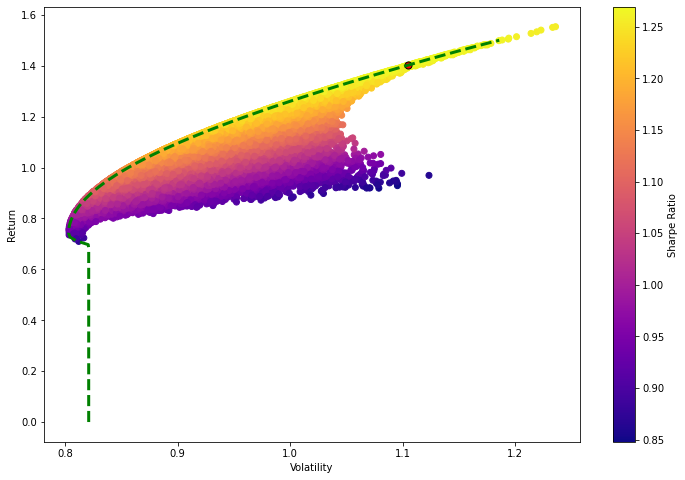

In [238]:
# Plotting the optimized results
# Scatter plot for the portfolio
plt.figure(figsize=(12,8))
plt.scatter(vol_array, ret_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Scatter the optimized sharpe ratio
max_sr_ret = get_ret_vol_sr(opt_results.x)[0]
max_sr_vol = get_ret_vol_sr(opt_results.x)[1]

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)

In [239]:
# Benchmarking the portfolio with buy and hold